<a href="https://www.kaggle.com/code/pmykola/kp10-titanic?scriptVersionId=102619345" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### This is a notebook, which generates predictions for Titanic passenger survival competition.
It's accuracy is up to 0.79425, a top 5\% result.

### Outline:
0. Load libraries and custom functions.
1. Load data.
2. Preliminary data analysis: explore features and a target, delete unneeded features, create new features.
3. Train-test split.
4. Missing values. In some cases it may be useful to explore skew and perform log-transform before imputing missing values.
5. Feature engineering. Transform skewed variables, do OHC and scaling.
6. Fit models.
7. Evaluate models.
8. Feature importance, error analysis. Based on the results, go to 2. and iterate.
9. Make predictions.

### To do:
- Add EDA visualization.
- Add SHAP feature importances.
- Add Optuna XGBoost hyperparameter tuning.
- Add PR curve analysis.

In [20]:
# 0. Load libraries #

import numpy as np
import pandas as pd
import os, time, warnings, shap, optuna
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 20)
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.expand_frame_repr', False)
warnings.filterwarnings('ignore')

# Load custom pre-processing functions:

def draw_histograms(df, variables, n_rows, n_cols):
    # stolen from https://stackoverflow.com/questions/29530355/plotting-multiple-histograms-in-grid
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  
    plt.show()


def fillna_mp_i1(df_train, df_test, df_pred, num_features, cat_features, num_fill='median', cat_fill='mode'):
    """This function speeds up filling missing values for 3 main datasets using different imputation methods.
    Later may replace it with some subclass.
    Example: fillna_mp_i1(X_train, X_test, X_pred, num_cols, cat_cols)"""
    # set df_pred to None if it does not exist
    if not ((cat_fill=='mode') and (num_fill=='median')):
        print ('Imputation method not Implemented yet!')
        return None
    
    df_train[num_features] = df_train[num_features].fillna(value=df_train[num_features].median())
    df_test[num_features] = df_test[num_features].fillna(value=df_train[num_features].median())
    df_train[cat_features] = df_train[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
    df_test[cat_features] = df_test[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
    if (df_pred is not None):
        df_pred[num_features] = df_pred[num_features].fillna(value=df_train[num_features].median())
        df_pred[cat_features] = df_pred[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
    df_train[num_features+cat_features].count
    
    all_good = (
    (np.prod(df_train[num_features+cat_features].shape)==df_train[num_features+cat_features].count().sum()) and 
    (np.prod(df_test[num_features+cat_features].shape) == df_test[num_features+cat_features].count().sum()) and 
    (np.prod(df_pred[num_features+cat_features].shape) == df_pred[num_features+cat_features].count().sum()))
    if (all_good):
        print('Missing values imputed successfully')
    else:
        print('There are still some missing values...')
    
def add_misDummy_mp_i1(df_train, df_test, df_pred, features):
    """This function creates new dummy columns for missing features.
    Example: add_misDummy_mp_i1(X_train, X_test, X_pred, ['Age'])"""
    # set df_pred to None if it does not exist
    for feature_name in features:
        misColName = 'mis'+feature_name
        df_train.loc[df_train[feature_name].isnull(), misColName]=1
        df_train.loc[df_train[feature_name].notnull(), misColName]=0
        df_test.loc[df_test[feature_name].isnull(), misColName]=1
        df_test.loc[df_test[feature_name].notnull(), misColName]=0
        if (df_pred is not None):
            df_pred.loc[df_pred[feature_name].isnull(), misColName]=1
            df_pred.loc[df_pred[feature_name].notnull(), misColName]=0
   

def discretize_mp_i1(df_train, df_test, df_pred, feature, ntiles, delete_feature=False):
    """This function divides a continuous feature into quantile groups.
    Example: discretize_mp_i1(X_train, X_test, X_pred, 'Age', 15)"""
    # set df_pred to None if it does not exist
    _,bin = pd.qcut(df_train[feature], ntiles, retbins = True, labels = False, duplicates = 'drop')
    df_train[feature+'Ntile'] = pd.cut(df_train[feature], labels=False, duplicates = 'drop', bins = bin ,include_lowest = True)
    df_test[feature+'Ntile'] = pd.cut(df_test[feature], labels=False, duplicates = 'drop', bins = bin ,include_lowest = True)
    if (df_pred is not None):
        df_pred[feature+'Ntile'] = pd.cut(df_pred[feature], labels=False, duplicates = 'drop', bins = bin ,include_lowest = True)
    if (delete_feature==True):
        df_train.drop(columns=[feature], inplace=True)
        df_test.drop(columns=[feature], inplace=True)
        df_pred.drop(columns=[feature], inplace=True)
    print('Discretized ',feature, ' into ', len(bin)-1, ' bins')


def log_transformer_mp_i1(df_train, df_test, df_pred, feature_subset=False, min_skew=3):
    """This function divides a continuous feature into quantile groups.
    Example: log_transformer_mp_i1(X_train, X_test, X_pred, feature_subset=num_cols)"""
    # set df_pred to None if it does not exist
    if (feature_subset==False):
        features_totransform = df_train.columns
    else:
        features_totransform = feature_subset.copy()
    skewed_vars = list(df_train.skew()[abs(df_train.skew())>min_skew].index)
    for col in list(set(skewed_vars)&set(features_totransform)):
        df_train[col] = np.log1p(df_train[col])
        df_test[col] = np.log1p(df_test[col])
        if (df_pred is not None):
            df_pred[col] = np.log1p(df_pred[col])
    print('Skewed columns log-transformed: ', list(set(skewed_vars)&set(features_totransform)))
    
    
# 1. Load data #

time0 = time.time()

path = '../input/titanic/train.csv'
df = pd.read_csv(path) 

df.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'],inplace=True)
pred=pd.read_csv('../input/titanic/test.csv')
pred0 = pred.copy()
pred.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'],inplace=True)

print(df.shape, pred.shape)
#df.head()

# 2. EDA, adding features #

#df.Survived.value_counts()
df['Age2'] = df['Age']**2
pred['Age2'] = pred['Age']**2

# 3. Train-test split #

train_y = df[['Survived']]
train_x = df.drop(columns = ['Survived'])
X_pred = pred.copy()

#bin_cols = [col for col in train_x.columns if train_x[col].nunique()==2]
cat_cols = [col for col in train_x.columns if train_x[col].nunique() in range(2,10)]
num_cols = list(set(train_x.columns)-set(cat_cols))

print('categorical features: ', cat_cols, 'numerical features: ', num_cols)

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.9, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, X_pred.shape)

X_train.info()

# 4. Misisng values #

add_misDummy_mp_i1(X_train, X_test, X_pred, ['Age'])

fillna_mp_i1(X_train, X_test, X_pred, num_cols, cat_cols)
#[X_train.count(), X_test.count(), X_pred.count()]

# extra feature engineering (manual)

discretize_mp_i1(X_train, X_test, X_pred, 'Age', 15)
discretize_mp_i1(X_train, X_test, X_pred, 'SibSp', 30)
discretize_mp_i1(X_train, X_test, X_pred, 'Parch', 60)

cat_cols.extend(['misAge', 'AgeNtile', 'SibSpNtile', 'ParchNtile'])
cat_cols = list(set(cat_cols)-set(['SibSp', 'Parch']))


# 5.Feature engineering #

log_transformer_mp_i1(X_train, X_test, X_pred, feature_subset=num_cols)

# in general, if I plan using raw ols, I should drop one group. o/w, it is beteer to leabe all ohc groups.

feature_transformer = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore"), cat_cols),
    ])

X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
X_pred = pd.DataFrame(feature_transformer.transform(X_pred), columns=feature_transformer.get_feature_names_out())

fewfeatures = ['num__Age', 'num__Age2', 'num__Fare', 'cat__Sex_male', 'cat__Pclass_2', 'cat__Pclass_3']

X_train

# 6. Fit models #

lr = LogisticRegression()
param_grid = {'C':[0.3, 1, 3, 10, 30]}
lrm = GridSearchCV(lr, param_grid, cv=8)
lrm.fit(X_train, y_train)
print('Logistic ', lrm.best_params_, accuracy_score(y_train, lrm.predict(X_train)))

svm = SVC()
param_grid = {'C':[0.3, 1, 2, 3, 10]}
svmm = GridSearchCV(svm, param_grid, cv=8)
svmm.fit(X_train, y_train)
print('SVM ', svmm.best_params_, accuracy_score(y_train, svmm.predict(X_train)))

knn = KNeighborsClassifier()
param_grid = dict(n_neighbors=range(2,20))
knnm = GridSearchCV(knn, param_grid, cv=8)
knnm.fit(X_train[fewfeatures], y_train)
print('KNN ', knnm.best_params_, accuracy_score(y_train, knnm.predict(X_train[fewfeatures])))

time1 = time.time()
rf = RandomForestClassifier()
param_grid = {'n_estimators':[100,200], 'max_depth':[2,4,6,8], 'max_features':[4,5,6]}
rfm = GridSearchCV(rf, param_grid, cv=4)
rfm.fit(X_train, y_train)
print('RF ', rfm.best_params_, accuracy_score(y_train, rfm.predict(X_train)), time.time()-time1)

time1 = time.time()
xgb = XGBClassifier()
# use 'gpu_hist' for more than 10,000 examples.
param_grid = {'n_estimators':[100,200], 'max_depth':[2,3,4], 'eta':[0.03, 0.04, 0.05], 'subsample':[0.4, 0.6],
             'colsample_bytree':[0.6, 0.8]}
xgbm = GridSearchCV(xgb, param_grid, cv=4)
xgbm.fit(X_train, y_train)
print('XGB ', xgbm.best_params_, accuracy_score(y_train, xgbm.predict(X_train)), time.time()-time1)

# 7. accuracy #

print('Out of Sample:')
print('Logistic ', accuracy_score(y_test, lrm.predict(X_test)))
print('SVM ', accuracy_score(y_test, svmm.predict(X_test)))
print('KNN ', accuracy_score(y_test, knnm.predict(X_test[fewfeatures])))
print('RF ', accuracy_score(y_test, rfm.predict(X_test)))
print('XGB ', accuracy_score(y_test, xgbm.predict(X_test)))
print('Total time ', time.time()-time0)

# VotingClassifier:

estimator = []
#estimator.append(('LR', LogisticRegression(C=1)))
estimator.append(('SVM', SVC(C=1, probability = True)))
#estimator.append(('KNN', KNeighborsClassifier(n_neighbors=5)))
estimator.append(('RF', RandomForestClassifier(max_depth=5, max_features=4, n_estimators=200)))
estimator.append(('XGB', XGBClassifier(eta=0.04, max_depth=3, n_estimators=200, 
                                       subsample=0.6, colsample_bytree=0.6)))
vot_soft = VotingClassifier(estimators = estimator, voting ='soft')
vot_soft.fit(X_train, y_train)
print('VotingClassifier5 ', accuracy_score(y_train, vot_soft.predict(X_train)))
print('VotingClassifier5 ', accuracy_score(y_test, vot_soft.predict(X_test)))
# to add KNN with different feature sets, 
# see https://stackoverflow.com/questions/45074579/votingclassifier-different-feature-sets

(891, 8) (418, 7)
categorical features:  ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked'] numerical features:  ['Age', 'Age2', 'Fare']
(89, 8) (802, 8) (89, 1) (418, 8)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 89 entries, 778 to 37
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    89 non-null     int64  
 1   Sex       89 non-null     object 
 2   Age       69 non-null     float64
 3   SibSp     89 non-null     int64  
 4   Parch     89 non-null     int64  
 5   Fare      89 non-null     float64
 6   Embarked  88 non-null     object 
 7   Age2      69 non-null     float64
dtypes: float64(3), int64(3), object(2)
memory usage: 6.3+ KB
Missing values imputed successfully
Discretized  Age  into  12  bins
Discretized  SibSp  into  4  bins
Discretized  Parch  into  5  bins
Skewed columns log-transformed:  []
Logistic  {'C': 30} 0.898876404494382
SVM  {'C': 1} 0.898876404494382
KNN  {'n_neighbors': 19} 0.719101

In [21]:
# 8. feature importance #

results = permutation_importance(xgbm, X_test, y_test, scoring='accuracy', n_jobs=-1)
fi_lr = pd.DataFrame({'col':X_test.columns, 'FI':results.importances_mean})
#fi_lr.sort_values('FI', ascending = False)

In [22]:
# 9. predictions #

submission_df_vc = pd.DataFrame({'PassengerId': pred0.PassengerId, 'Survived': vot_soft.predict(X_pred)}, columns=['PassengerId', 'Survived'])
submission_df_svm = pd.DataFrame({'PassengerId': pred0.PassengerId, 'Survived': svmm.predict(X_pred)}, columns=['PassengerId', 'Survived'])
submission_df_rf = pd.DataFrame({'PassengerId': pred0.PassengerId, 'Survived': rfm.predict(X_pred)}, columns=['PassengerId', 'Survived'])
submission_df_bt = pd.DataFrame({'PassengerId': pred0.PassengerId, 'Survived': xgbm.predict(X_pred)}, columns=['PassengerId', 'Survived'])

submission_df_vc.to_csv('KP10_v2_vc.csv',index=False)
submission_df_svm.to_csv('KP10_v2_svm.csv',index=False)
submission_df_rf.to_csv('KP10_v2_rf.csv',index=False)
submission_df_bt.to_csv('KP10_v2_bt.csv',index=False)

os.chdir(r'/kaggle/working')

from IPython.display import FileLink
FileLink(r'KP10_v2_vc.csv')

display(time.time()-time0)

149.32207083702087

### Appendix:
#### Exploring XGBoost predictions with PR curve

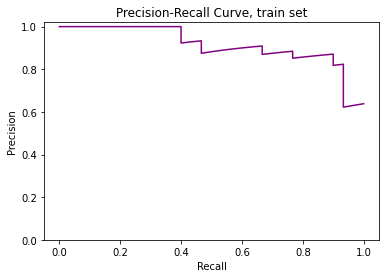

In [23]:
# Precision-Recall curve in train set
precision_t, recall_t, threshold = precision_recall_curve(y_train, xgbm.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, train set')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

In [24]:
display(xgbm.predict_proba(X_train)[:, 1])
display(precision_t, recall_t, threshold)

array([0.03317617, 0.03764636, 0.23632544, 0.02071769, 0.7616029 ,
       0.16006081, 0.22164656, 0.44214284, 0.8470806 , 0.75416857,
       0.71606696, 0.03317617, 0.5130294 , 0.63177913, 0.5987504 ,
       0.10737102, 0.17407238, 0.02669454, 0.03204371, 0.01904237,
       0.5116204 , 0.697447  , 0.03317617, 0.18051074, 0.6809779 ,
       0.0246946 , 0.7534662 , 0.7659654 , 0.21591587, 0.8441618 ,
       0.05138534, 0.03029914, 0.8066688 , 0.0517868 , 0.25976118,
       0.33890966, 0.76299626, 0.06303768, 0.01868732, 0.75037724,
       0.3717628 , 0.3357812 , 0.24138334, 0.03324168, 0.70860535,
       0.86611414, 0.38034484, 0.09976661, 0.37372082, 0.6347468 ,
       0.83380437, 0.94437367, 0.01586867, 0.17701931, 0.86002296,
       0.9459013 , 0.03231595, 0.9337184 , 0.5194871 , 0.09814857,
       0.03435593, 0.27743763, 0.02454705, 0.90620226, 0.7692254 ,
       0.0445    , 0.02662096, 0.04425956, 0.09667514, 0.24138334,
       0.03317617, 0.6400042 , 0.4079098 , 0.28122175, 0.03764

array([0.63829787, 0.63043478, 0.62222222, 0.65116279, 0.66666667,
       0.68292683, 0.7       , 0.71794872, 0.73684211, 0.75675676,
       0.77777778, 0.8       , 0.82352941, 0.81818182, 0.84375   ,
       0.87096774, 0.86666667, 0.86206897, 0.85714286, 0.85185185,
       0.88461538, 0.88      , 0.875     , 0.86956522, 0.90909091,
       0.9047619 , 0.9       , 0.89473684, 0.88888889, 0.88235294,
       0.875     , 0.93333333, 0.92857143, 0.92307692, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

array([1.        , 0.96666667, 0.93333333, 0.93333333, 0.93333333,
       0.93333333, 0.93333333, 0.93333333, 0.93333333, 0.93333333,
       0.93333333, 0.93333333, 0.93333333, 0.9       , 0.9       ,
       0.9       , 0.86666667, 0.83333333, 0.8       , 0.76666667,
       0.76666667, 0.73333333, 0.7       , 0.66666667, 0.66666667,
       0.63333333, 0.6       , 0.56666667, 0.53333333, 0.5       ,
       0.46666667, 0.46666667, 0.43333333, 0.4       , 0.4       ,
       0.36666667, 0.33333333, 0.3       , 0.26666667, 0.23333333,
       0.2       , 0.16666667, 0.13333333, 0.1       , 0.06666667,
       0.03333333, 0.        ])

array([0.22164656, 0.23632544, 0.24138334, 0.25976118, 0.27743763,
       0.28122175, 0.2828721 , 0.30032283, 0.3357812 , 0.33890966,
       0.3717628 , 0.37372082, 0.38034484, 0.4079098 , 0.44214284,
       0.4993533 , 0.5116204 , 0.5130294 , 0.5194871 , 0.54540753,
       0.5987504 , 0.63177913, 0.6347468 , 0.6400042 , 0.6809779 ,
       0.69495314, 0.697447  , 0.70860535, 0.71606696, 0.75037724,
       0.7534662 , 0.75416857, 0.7616029 , 0.76299626, 0.7659654 ,
       0.7692254 , 0.8066688 , 0.83380437, 0.8441618 , 0.8470806 ,
       0.86002296, 0.86611414, 0.90620226, 0.9337184 , 0.94437367,
       0.9459013 ], dtype=float32)

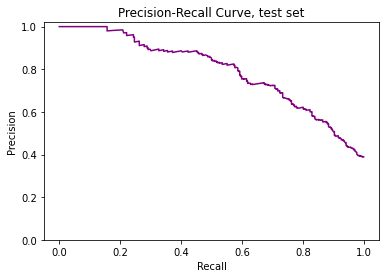

In [25]:
# Precision-Recall curve in test set
precision_t, recall_t, threshold = precision_recall_curve(y_test, xgbm.predict_proba(X_test)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.18)&(recall_t<0.22)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, test set')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

In [26]:
# for those examples, which the model is confident about, it could make sense to set predicted probability as 1.